In [279]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

from sklearn import preprocessing as sklpp
from sklearn.decomposition import PCA
import glob
import seaborn as sbn
import os 
import time 

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import sklearn.metrics

In [280]:
coverDF = pd.read_csv('/Users/RishiShah/Desktop/ML Project/DataSet2/archive (10)/train.csv')



## a. Brief Exploration of Dataset

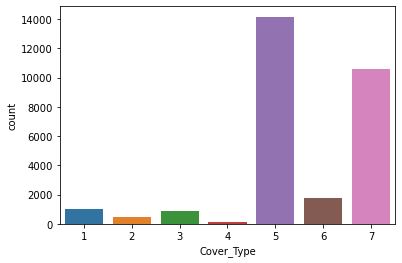

In [281]:
sbn.countplot(x="Cover_Type",data=coverDF)

In [282]:
print("Total number of samples: ",coverDF.shape[0])
print("Total number of samples for Cover Type 1: ", coverDF.loc[coverDF['Cover_Type']==1].shape[0])
print("Total number of samples for Cover Type 2: ", coverDF.loc[coverDF['Cover_Type']==2].shape[0])
print("Total number of samples for Cover Type 3: ", coverDF.loc[coverDF['Cover_Type']==3].shape[0])
print("Total number of samples for Cover Type 4: ", coverDF.loc[coverDF['Cover_Type']==4].shape[0])
print("Total number of samples for Cover Type 5: ", coverDF.loc[coverDF['Cover_Type']==5].shape[0])
print("Total number of samples for Cover Type 6: ", coverDF.loc[coverDF['Cover_Type']==6].shape[0])
print("Total number of samples for Cover Type 7: ", coverDF.loc[coverDF['Cover_Type']==7].shape[0])

Total number of samples:  29050
Total number of samples for Cover Type 1:  1025
Total number of samples for Cover Type 2:  475
Total number of samples for Cover Type 3:  868
Total number of samples for Cover Type 4:  137
Total number of samples for Cover Type 5:  14165
Total number of samples for Cover Type 6:  1788
Total number of samples for Cover Type 7:  10592


There are 29050 samples in this dataset. The number of samples in each class varies greatly, with Cover Type 5 and 7 having the most samples and Cover Type 4 and 2 having the least samples.

In [283]:
print("Total number of features: ", coverDF.shape[1]-1)

Total number of features:  54


The total number of features is 54 (subtracted one because I'm not counting the label). This is a supervised/labeled dataset.

In [284]:
coverDF.head()

,Elevation(meters),Aspect(degrees),Slope(degrees),Horizontal_Distance_To_Hydrology(meters),Vertical_Distance_To_Hydrology(meters),Horizontal_Distance_To_Roadways(meters),Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points(meters),...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2982,186,14,323,66,5351,222,249,158,1530,...,0,0,0,0,0,0,0,0,0,5
1,2929,243,15,335,33,5778,189,251,198,6429,...,0,0,0,0,0,0,0,0,0,7
2,3051,162,12,1224,253,3182,231,243,142,1167,...,0,0,1,0,0,0,0,0,0,5
3,3090,345,17,362,92,2460,184,211,164,2384,...,0,0,0,0,0,0,0,0,0,7
4,3023,4,9,234,51,4994,208,222,151,3813,...,0,0,0,0,0,0,0,0,0,7


From the data above it is clear that we have some categorical variables in our dataset, such as 40 soil types and 4 wilderness areas. This data is one-hot encoded, meaning that it is split into n columns, with n representing the number of types for that categorical variable. We can see from this then, that 44 features are categorical, while 10 features are integer/numerical. In addition, the label/output Cover_Type is also categorical, and it is label encoded.

## b. Preprocessing

In [285]:
from sklearn.utils import resample
majorityClasses = coverDF[coverDF.Cover_Type ==5]
majorityClasses = majorityClasses.append(coverDF[coverDF.Cover_Type==6])
majorityClasses = majorityClasses.append(coverDF[coverDF.Cover_Type==7])
majorityClasses.shape

(26545, 55)

In [286]:
minorityClasses = coverDF[coverDF.Cover_Type ==2]
minorityClasses = minorityClasses.append(coverDF[coverDF.Cover_Type==3])
minorityClasses = minorityClasses.append(coverDF[coverDF.Cover_Type==4])
#minorityClasses[minorityClasses.Cover_Type==2]

In [287]:
majorityClassesDownsample = pd.DataFrame()
for i in range(5,8):
    addThis = resample(majorityClasses[majorityClasses.Cover_Type== i ], 
                                    replace=True,     # sample with replacement
                                    n_samples=1025,    # to match majority class
                                    random_state=123) # reproducible results
    majorityClassesDownsample = majorityClassesDownsample.append(addThis)

majorityClassesDownsample.shape

(3075, 55)

In [288]:
minorityClassesUpsample = pd.DataFrame()
for i in range(2,5):
    addThis = resample(minorityClasses[minorityClasses.Cover_Type== i ], 
                                    replace=True,     # sample with replacement
                                    n_samples=1025,    # to match majority class
                                    random_state=123) # reproducible results
    minorityClassesUpsample = minorityClassesUpsample.append(addThis)

minorityClassesUpsample.shape

(3075, 55)

In [289]:
trainDF = pd.concat([coverDF[coverDF.Cover_Type ==1], minorityClassesUpsample, majorityClassesDownsample])
trainDF.shape

(7175, 55)

To make the samples evenly distributed, I took the median value of the samples from above, which was 1025, and upsampled each of the cover type classes (2,3,4) that had less samples than that number. Similarly, I downsampled (5,6,7) each of the cover type classes that had more samples than that number. I did this because the dataset was significantly imbalanced, which means that any accuracy that I got, especially for classifiers such as KNN, would be misleading because there are a vast majority of samples in classes 5 and 7. You can see in below's graph that now each class has 1025 samples. 

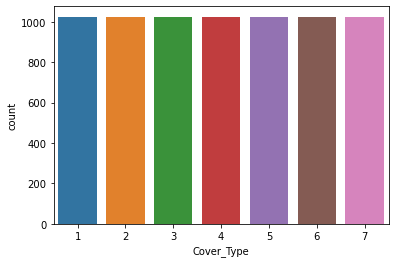

In [290]:
sbn.countplot(x="Cover_Type",data=trainDF)

In [291]:
coverType = pd.DataFrame(trainDF.Cover_Type)
trainDF = trainDF.drop('Cover_Type',axis=1)

In [292]:
scalar = StandardScaler()
trainDF = scalar.fit_transform(trainDF)

In this step, for the purposes of making the data Gaussian (so that it can be better used with certain classification methods later on), I shall standardize the data with StandardScaler. I do not need to do anything else for this step, as all the categorical data is already one-hot encoded.

## c. Feature Learning

Feature learning isn't really necessary here, specifically PCA, as there already are a small number of features (54), many of which are categorical to begin with. 

## d. Processing

In [293]:
coverType = np.array(coverType)
trainDF, coverType = shuffle(trainDF,coverType)

 Right now, each class's data is grouped together from the preprocessing that I did before. I shuffle the data here to get rid of this and reduce bias when it comes time to training the model.

### a. Linear Discriminant Analysis (LDA)

In [347]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

folds = KFold(n_splits=5)
count = 0
ldaTime = 0
ldaAccuracy = 0
ldaError = 0
ldaPredictions = []
for i, j in folds.split(trainDF):
    temp = time.time()
    cvXTrain, cvXTest = trainDF[i],trainDF[j]
    cvYTrain, cvYTest = coverType[i],coverType[j]

    ldaClf = LDA().fit(cvXTrain,cvYTrain)
    #ldaClf.fit(cvXTrain,cvYTrain)
#IMPLEMENT BALANCED ACCURACY
    ldaResults = ldaClf.predict(cvXTest)
    ldaPredictions = np.append(ldaPredictions, ldaResults)
    print("Accuracy: ", sklearn.metrics.accuracy_score(cvYTest, ldaResults), "Test Error: ", sklearn.metrics.mean_squared_error(cvYTest, ldaResults))
    #print(sklearn.metrics.classification_report(cvYTest, ldaResults))
    count = count+1
    ldaAccuracy += sklearn.metrics.accuracy_score(cvYTest, ldaResults)
    ldaError += sklearn.metrics.mean_squared_error(cvYTest, ldaResults)
    ldaTime = ldaTime + (time.time() - temp)


ldaAccuracy = ldaAccuracy/5
ldaError = ldaError/5
ldaTime = ldaTime/5
print("Average Time: ", ldaTime)
print("Average Accuracy: ", ldaAccuracy)
print("Average Error: ", ldaError)
ldaPredictions.shape

Accuracy:  0.6668989547038328 Test Error:  3.462717770034843
Accuracy:  0.6452961672473868 Test Error:  3.5491289198606273
Accuracy:  0.6439024390243903 Test Error:  3.6132404181184667
Accuracy:  0.6376306620209059 Test Error:  3.772822299651568
Accuracy:  0.6313588850174217 Test Error:  3.6766550522648083
Average Time:  0.057916450500488284
Average Accuracy:  0.6450174216027874
Average Error:  3.614912891986063


(7175,)

Text(0.5, 0.98, 'Confusion Matrix for LDA')

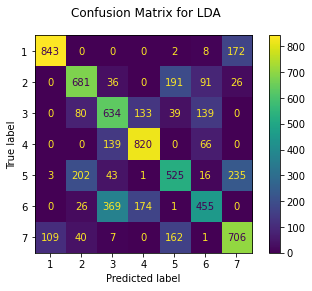

In [323]:
ldaConfusionMatrix = sklearn.metrics.plot_confusion_matrix(ldaClf, trainDF,coverType)
ldaConfusionMatrix.figure_.suptitle("Confusion Matrix for LDA")

I performed Linear Discriminant Analysis here as my first classifier because the data was standardized from earlier when I used StandardScaler. This means that the mean is 0 and the variance is 1. Regarding the actual process I used, I had to use k-fold cross validation (over 5 folds in this case), but only for the test error phase, as I did not have any hyperparameters for LDA. I had to this because even though there was test data, it was not labeled. So, I decided to use cross-validation on solely the training data, which had an ample number of samples. 


### b. K-Nearest Neighbors

In [296]:
from sklearn.neighbors import KNeighborsClassifier as knn

In [297]:
folds = KFold(n_splits=5)
count = 0
ks = [60,70,80,90,100]
#print(len(trainDF))
for i, j in folds.split(trainDF):
    temp = time.time()
    cvXTrain, cvXTest = trainDF[i],trainDF[j]
    cvYTrain, cvYTest = coverType[i],coverType[j]

    knnClf = knn(n_neighbors = ks[count], weights ="uniform").fit(cvXTrain,cvYTrain)
    #knnClf.fit(cvXTrain,cvYTrain)
#IMPLEMENT BALANCED ACCURACY
    knnResults = knnClf.predict(cvXTest)
    print("K value: ", ks[count], "Accuracy: ", sklearn.metrics.accuracy_score(cvYTest, knnResults), "Validation Error: ", sklearn.metrics.mean_squared_error(cvYTest, knnResults))
    count = count+1
    



  

K value:  60 Accuracy:  0.6627177700348432 Validation Error:  3.3233449477351917
K value:  70 Accuracy:  0.6285714285714286 Validation Error:  3.700348432055749
K value:  80 Accuracy:  0.6055749128919861 Validation Error:  3.74006968641115
K value:  90 Accuracy:  0.6146341463414634 Validation Error:  3.854355400696864
K value:  100 Accuracy:  0.6020905923344948 Validation Error:  4.003484320557491


In [298]:
folds = KFold(n_splits=5)
count = 0
knnTime = 0
knnAccuracy = 0
knnError = 0

for i, j in folds.split(trainDF):
    temp = time.time()
    cvXTrain, cvXTest = trainDF[i],trainDF[j]
    cvYTrain, cvYTest = coverType[i],coverType[j]

    knnClf = knn(n_neighbors=60, weights="uniform").fit(cvXTrain,cvYTrain)

#IMPLEMENT BALANCED ACCURACY
    knnResults = knnClf.predict(cvXTest)
    print("Accuracy: ", sklearn.metrics.accuracy_score(cvYTest, knnResults), "Test Error: ", sklearn.metrics.mean_squared_error(cvYTest, knnResults))
    count = count+1
    knnAccuracy += sklearn.metrics.accuracy_score(cvYTest, knnResults)
    knnError += sklearn.metrics.mean_squared_error(cvYTest, knnResults)
    knnTime = knnTime + (time.time() - temp)


knnAccuracy = knnAccuracy/5
knnError = knnError/5
knnTime = knnTime/5
print("Average Time: ", knnTime)
print("Average Accuracy: ", knnAccuracy)
print("Average Test Error: ", knnError)
  

Accuracy:  0.6627177700348432 Test Error:  3.3233449477351917
Accuracy:  0.6425087108013937 Test Error:  3.6257839721254355
Accuracy:  0.6466898954703832 Test Error:  3.4982578397212545
Accuracy:  0.6390243902439025 Test Error:  3.8508710801393726
Accuracy:  0.6292682926829268 Test Error:  3.8062717770034844
Average Time:  0.7656367301940918
Average Accuracy:  0.6440418118466898
Average Test Error:  3.620905923344948


Text(0.5, 0.98, 'Confusion Matrix for KNN')

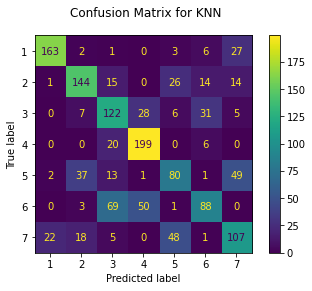

In [299]:
knnConfusionMatrix = sklearn.metrics.plot_confusion_matrix(knnClf, cvXTest, cvYTest)
knnConfusionMatrix.figure_.suptitle("Confusion Matrix for KNN")

I was able to perform K-Nearest Neighbors here due to the fact that I made the distribution of samples per class even. If this wasn't the case, then the test samples would more often than not be assigned to the majority classes (which were 5 and 7), giving a false representation of accuracy. When I performed KNN here, I had to do cross validation twice. The first time I did it to find the best value for number of neighbors, which from my research, I found to be square root of n. Thus, I tested 5 k values across 5 folds, around this number (about 80), and found that the best k value was 60 because it had the lowest validation error. Next, I used the value for 60 as the number of neighbors to again run cross validation across 5 folds, this time averaging all the accuracies/test errors. 

### c. Support Vector Classifier

In [302]:
from sklearn.svm import SVC as SVC

In [307]:
folds = KFold(n_splits=5)
count = 0
Cs = [100,10,1,0.1,0.01]
#print(len(trainDF))
for i, j in folds.split(trainDF):
    temp = time.time()
    cvXTrain, cvXTest = trainDF[i],trainDF[j]
    cvYTrain, cvYTest = coverType[i],coverType[j]

    svcClf = SVC(C = Cs[count], tol = 0.1, max_iter=5000).fit(cvXTrain,cvYTrain)
   
#IMPLEMENT BALANCED ACCURACY
    svcResults = svcClf.predict(cvXTest)
    print("C value: ", Cs[count], "Accuracy: ", sklearn.metrics.accuracy_score(cvYTest, svcResults), "Validation Error: ", sklearn.metrics.mean_squared_error(cvYTest, svcResults))
    count = count+1
    



  

C value:  100 Accuracy:  0.6278745644599303 Validation Error:  4.032752613240418
C value:  10 Accuracy:  0.6759581881533101 Validation Error:  3.154703832752613
C value:  1 Accuracy:  0.6668989547038328 Validation Error:  3.3832752613240418
C value:  0.1 Accuracy:  0.6738675958188153 Validation Error:  3.7930313588850173
C value:  0.01 Accuracy:  0.6362369337979094 Validation Error:  3.7177700348432055


In [308]:
folds = KFold(n_splits=5)
count = 0
svcTime = 0
svcAccuracy = 0
svcError = 0

for i, j in folds.split(trainDF):
    temp = time.time()
    cvXTrain, cvXTest = trainDF[i],trainDF[j]
    cvYTrain, cvYTest = coverType[i],coverType[j]

    svcClf = SVC(C = 10, tol = 0.1, max_iter=5000).fit(cvXTrain,cvYTrain)

#IMPLEMENT BALANCED ACCURACY
    svcResults = svcClf.predict(cvXTest)
    print("Accuracy: ", sklearn.metrics.accuracy_score(cvYTest, svcResults), "Test Error: ", sklearn.metrics.mean_squared_error(cvYTest, svcResults))
    count = count+1
    svcAccuracy += sklearn.metrics.accuracy_score(cvYTest, svcResults)
    svcError += sklearn.metrics.mean_squared_error(cvYTest, svcResults)
    svcTime = svcTime + (time.time() - temp)


svcAccuracy = svcAccuracy/5
svcError = svcError/5
svcTime = svcTime/5
print("Average Time: ", svcTime)
print("Average Accuracy: ", svcAccuracy)
print("Average Test Error: ", svcError)
  

Accuracy:  0.6857142857142857 Test Error:  3.1491289198606274
Accuracy:  0.6752613240418118 Test Error:  3.189547038327526
Accuracy:  0.667595818815331 Test Error:  3.4125435540069686
Accuracy:  0.6745644599303136 Test Error:  3.7609756097560973
Accuracy:  0.6494773519163763 Test Error:  3.5254355400696866
Average Time:  23.989805746078492
Average Accuracy:  0.6705226480836236
Average Test Error:  3.4075261324041812


Text(0.5, 0.98, 'Confusion Matrix for SVC')

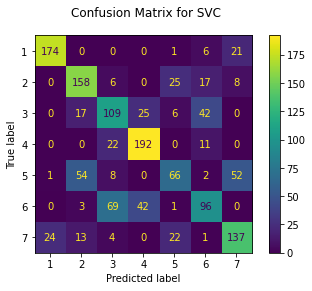

In [309]:
svcConfusionMatrix = sklearn.metrics.plot_confusion_matrix(svcClf, cvXTest, cvYTest)
svcConfusionMatrix.figure_.suptitle("Confusion Matrix for SVC")

I chose to do SVC here with the radial kernel because it can transform the data into higher dimensions and form better decision boundaries. I did this because the data may not be linearly separable. The accuracy here was better than both LDA and KNN, which means that doing this was a good choice. 


## e. Comparison 

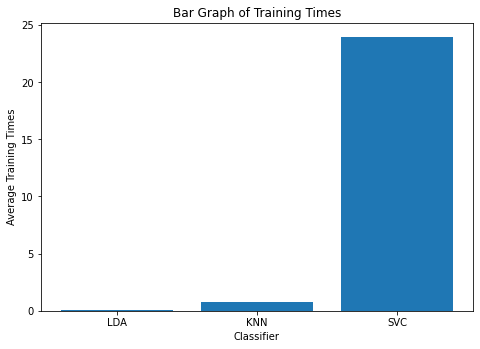

In [353]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['LDA', 'KNN', 'SVC']
values = [ldaTime, knnTime, svcTime]
ax.bar(labels, values)
ax.set_xlabel('Classifier')
ax.set_ylabel('Average Training Times')
ax.set_title("Bar Graph of Training Times")
fig.show()



It is evident from this graph that SVC took the most time to run. One reason this is true is because we had to do two cross validation runs. The first was to find the best hyperparameter and the second was to take the average of the accuracies/test errors with the best hyperparameter. In addition, because SVC uses a radial kernel, which is more complex since it is non-linear. LDA takes the shortest time because there are no hyperparameters. 

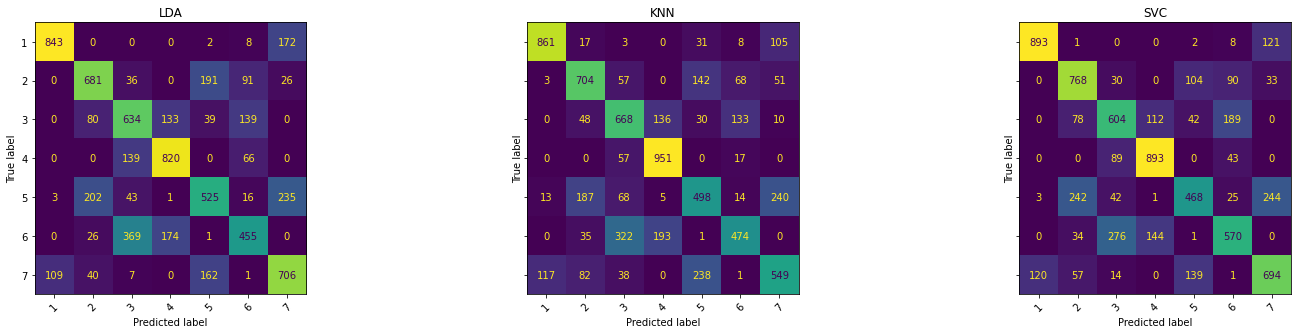

In [346]:
#describe confusion matrices and ROC differences/purposes here
#can only use ROC for binary
fig, axes = plt.subplots(1,3, figsize=(25,5), sharey = 'row')
classifiers = [ldaClf, knnClf, svcClf]
classifierName = ['LDA', 'KNN', 'SVC']

for i in range(3):
    confusionMatrix = sklearn.metrics.plot_confusion_matrix(classifiers[i], trainDF, coverType, xticks_rotation=45, ax = axes[i])
    confusionMatrix.ax_.set_title(classifierName[i])
    confusionMatrix.im_.colorbar.remove()
  



From these confusion matrices, as well as the accuracies found in the part above, it is clear that SVC was the best classifier for this dataset. It had the most true positives and true negatives, which can be seen on the diagonal. The false negatives can be seen on the bottom left triangle and the false positives are on the top right. 

It is evident from these findings that SVC should be used for this dataset (at least from the three classifiers that I chose). One reason this may be true is because the data may not be linearly separable, and using a non-linear kernel like the rbf (radial kernel) in SVC, allowed for better accuracy.

## f. Ethical Issues for Dataset

An ethical issue about this dataset is that you could be disrupting the land/areas whereever you are collecting this data. This could end up disrupting wildlife and the environment around them, causing shifts in their ecosystem. 

## g. Bibliography 



Band, Amey. “How to Find the Optimal Value of K in KNN?” Medium, Towards Data Science, 23 May 2020, towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb. 

Brownlee, Jason. “Multi-Class Imbalanced Classification.” Machine Learning Mastery, 20 Aug. 2020, machinelearningmastery.com/multi-class-imbalanced-classification/. 

Gupta, Rahul. “Machinehack Forest Cover Classification.” Kaggle, 13 Aug. 2020, www.kaggle.com/rahulgupta21/machinehack-forest-cover-classification. 

“How to Handle Imbalanced Classes in Machine Learning.” EliteDataScience, 23 May 2020, elitedatascience.com/imbalanced-classes. 

“Plotting Multiple Confusion Matrix Side by Side.” Stack Overflow, 1 June 1969, stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side. 

“Sklearn.svm.SVC.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html. 

“Sklearn.discriminant_analysis.LinearDiscriminantAnalysis¶.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html. 

